This notebook contains some experimentation I've been doing with making it easier to get data to plot. In this case, I'm trying to make it easier to customize a dot plot (using [`altair`](https://altair-viz.github.io/index.html)) for differential expression.

In [1]:
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import xarray as xr

from typing import Iterable, Optional

In [2]:
sc.settings.datasetdir = "../data"

In [3]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Defining functions

Adding `groupby` functionality to `AnnData` to help calculate some aggregate gene metrics for each group.

In [4]:
class Grouped(object):
    """
    Generic grouped object for split-apply-combine style workflows.
    
    Designed to be used with chainable calls.
    """
    def __init__(self, groups: dict):
        self.groups = groups
    
    def __iter__(self):
        for k, v in self.groups.items():
            yield (k, v)

    def apply(self, func):
        """
        Apply func to each value, returning a Grouped result.
        """
        return Grouped({k: func(v) for k, v in self})
    
    def mutate(self, func):
        """
        Apply mutating func to each value.
        
        In contrast with apply, this method assumes passed `func` modifies 
        the values in place, and return the current Grouped.
        """
        for k, v in self:
            func(v)
        return self
    
    def combine(self, func):
        return func(self.groups)
    

def groupby(adata, *, obs=None, var=None):
    is_obs = obs is not None
    is_var = var is not None
    if is_obs == is_var:
        raise ValueError("Can only groupby obs or var")
    if is_obs:
        dim = 0
        grouped = adata.obs.groupby(obs)
        make_idx = lambda x: (x, slice(None))
    elif is_var:
        dim =1
        grouped = adata.var.groupby(var)
        make_idx = lambda x: (slice(None), x)
    return Grouped({k: adata[make_idx(v.index)] for k, v in grouped})

# To get values by leiden
setattr(AnnData, "groupby", groupby)

`rank_genes_groups_df` is to make it less painful to work with the output of `sc.tl.rank_genes_groups`. I'm aiming on adding this to `sc.utils` by `v1.5`.

In [5]:
def rank_genes_groups_df(
    adata: AnnData,
    group: str,  # Can this be something other than a str?
    *,
    genes: Optional[Iterable[str]] = None,  # TODO: Implement
    key: str = "rank_genes_groups",
    pval_cutoff: Optional[float] = 0.05,
    logfc_cutoff: Optional[float] = None,
    gene_symbols: Optional[str] = None
) -> pd.DataFrame:
    """
    Get `rank_genes_groups` results in the form of a :class:`pd.DataFrame`.

    Params
    ------
    adata
        Object to get results from.
    group
        Which group (key from :func:`scanpy.tl.rank_genes_groups` `groupby`) to
        return results from.
    genes
        Only return values for these genes.
    key
        Key differential expression groups were stored under.
    pval_cutoff
        Minimum adjusted pval to return.
    logfc_cutoff
        Minumum logfc to return.
    gene_symbols
        Column name in `.var` DataFrame that stores gene symbols. By default `var_names` 
        refer to the index column of the `.var` DataFrame. Setting this option allows
        alternative names to be used.
    """
    d = pd.DataFrame()
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']:
        d[k] = adata.uns["rank_genes_groups"][k][group]
    if pval_cutoff is not None:
        d = d[d["pvals_adj"] < pval_cutoff]
    if logfc_cutoff is not None:
        d = d[d["logfoldchanges"].abs() > logfc_cutoff]
    if gene_symbols is not None:
        d = d.join(adata.var[gene_symbols], on="names")
    return d

In [6]:
def de_dataset(adata, *, grouper=None, key="rank_genes_groups"):
    """
    Versus rest, style de tests returned as an xarray dataset.
    
    Really, this is just to make the "rank_genes_groups" results easier to work with.
    It should also be pretty straight forwards to get this working with diffxpy.
    
    Returns
    -------
    An xarray dataset with `genes`, `groups` as coordinate dimensions.
    """
    keys = ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    genes_index = pd.Index(adata.var_names, name="genes")
    # Make sure we've got DE values:
    if grouper:
        sc.tl.rank_genes_groups(adata, groupby=grouper, key_added=key, method="wilcoxon", n_genes=adata.shape[1])
    else:
        grouper = pbmc.uns["rank_genes_groups"]["params"]["groupby"]
    groups = adata.obs[grouper].cat.categories
    dedfs = {}
    for g in groups:
        dedf = rank_genes_groups_df(pbmc, g, pval_cutoff=None).set_index("names")
        dedf.index.name = "genes"
        dedfs[g] = dedf
    results = xr.Dataset(coords={"genes": adata.var_names, "group": groups})
    for k in keys:
        df = pd.DataFrame(index=genes_index)
        for g in groups:
            df[g] = dedfs[g][k]
        df.columns.name = "group"
        results[k] = df
    return results

# Usage:

## From counts (including preprocessing):

In [7]:
pbmc = sc.datasets.pbmc3k() # Gotta use a dataset where I have reasonable count values
sc.pp.filter_genes(pbmc, min_counts=1)
# pbmc.var["mito"] = pbmc.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(pbmc, qc_vars=["mito"], inplace=True)
sc.pp.normalize_per_cell(pbmc, counts_per_cell_after=1000)
sc.pp.log1p(pbmc)
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.leiden(pbmc)

In [8]:
%time diffx = de_dataset(pbmc, grouper="leiden")  # Slower than I would like

CPU times: user 5.71 s, sys: 1.74 s, total: 7.45 s
Wall time: 7.46 s


In [9]:
leiden_grouped = pbmc.groupby(obs="leiden")

means = (
    leiden_grouped
    .apply(lambda adata: pd.Series(np.ravel(adata.X.mean(axis=0)), index=adata.var_names))
    .combine(pd.DataFrame)
)
means.index.name, means.columns.name = "genes", "group"
diffx["means"] = means

pct_expressed = (
    leiden_grouped
    .apply(lambda adata: pd.Series(np.ravel((adata.X != 0).sum(axis=0) / adata.shape[0]), index=adata.var_names))
    .combine(pd.DataFrame)
)
pct_expressed.index.name, pct_expressed.columns.name = "genes", "group"
diffx["pct_expressed"] = pct_expressed

In [10]:
diffx

<xarray.Dataset>
Dimensions:         (genes: 16634, group: 10)
Coordinates:
  * genes           (genes) object 'AL627309.1' 'AP006222.2' ... 'SRSF10-1'
  * group           (group) object '0' '1' '2' '3' '4' '5' '6' '7' '8' '9'
Data variables:
    logfoldchanges  (genes, group) float32 -1.4300877 3.0801282 ... -23.030983
    pvals           (genes, group) float64 0.948 0.7053 0.9873 ... 0.5076 0.8831
    pvals_adj       (genes, group) float64 0.9996 0.9999 1.0 ... 0.9986 0.9988
    scores          (genes, group) float32 -0.06527658 ... -0.14707822
    means           (genes, group) float32 0.00047222507 0.0040058913 ... 0.0
    pct_expressed   (genes, group) float64 0.001876 0.01227 ... 0.08163 0.0

## Plotting

In [11]:
marker_genes = ['CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ',  'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'FCER1A', 'CST3']

plotdf = diffx.loc[{"genes": marker_genes}].to_dataframe().reset_index()

In [12]:
plotdf.head()

,genes,group,logfoldchanges,pvals,pvals_adj,scores,means,pct_expressed
0,CD79A,0,-3.065463,4.449992e-06,2.615589e-04,-4.589176,0.022879,0.061914
1,CD79A,1,-3.809518,1.202422e-07,3.752549e-06,-5.293127,0.013637,0.036810
2,CD79A,2,-4.300896,8.722850e-07,9.421811e-05,-4.918458,0.009182,0.017192
3,CD79A,3,6.616068,2.264877e-170,1.255799e-166,27.823336,1.022081,0.933526
4,CD79A,4,-3.273080,1.144630e-04,5.159829e-03,-3.857692,0.018278,0.046440


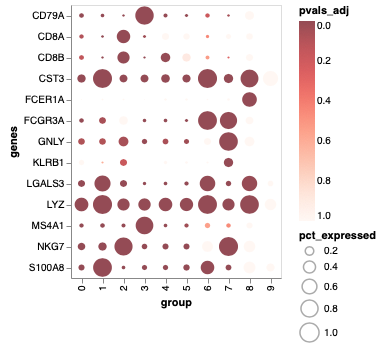

In [13]:
alt.Chart(plotdf).mark_circle().encode(
    x='group:O',
    y='genes:O',
    size='pct_expressed:Q',
    color=alt.Color(
        "pvals_adj:Q",
        scale=alt.Scale(domain=[1,0], scheme="reds")
    )
)